# <a id="creditcard"> Credit Card Fraud Detection</a>

<img src='https://wallpaperaccess.com/full/2666312.jpg' height=700 width=500/>
<br>

Credit card fraud is a wide-ranging term for theft and fraud committed using or involving a payment card, such as a credit card or debit card, as a fraudulent source of funds in a transaction. The purpose may be to obtain goods without paying or to obtain unauthorized funds from an account. Credit card fraud is also an adjunct to identity theft.
Although incidences of credit card fraud are limited to about 0.1% of all card transactions, they have resulted in huge financial losses as the fraudulent transactions have been large value transactions. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. What we need is an algorithm, which could classify a transaction as fraudulent or non-fraudulent. Doing so will benefit both the credit card companies and the customers who have to go through the ordeal.

# Table of Contents
- [Credit Card Fraud Detection](#creditcard)
- [Dataset and Preprocessing](#dataset)
    - [Feature Scaling](#feature)
    - [Exploratory Data Analysis](#eda)
    - [Correlation Matrices](#corr)
    - [Histograms](#hist)
    - [Boxplots](#box)
    - [Outlier Detection and Removal](#outlier)
- [Naive Predictor Performance](#naive)
- [Classifiers (Undersampling)](#classifier)
    - [Cross-Validation](#crossval)
    - [Learning Curve](#learn)
    - [AUC-ROC Curve](#roc)
- [Undersampling vs Oversampling](#sampling)
    - [Undersampling](#under)
    - [Oversampling(SMOTe Technique)](#over)
- [Neural Network testing Random undersampled data vs Oversampled data(SMOTe)](#neuralnet)
    - [Confusion Matrix](#conf)
    - [Testing on Random undersampled data](#test_under)
    - [Testing on Oversampled data(SMOTe Technique)](#test_over)
- [Conclusion](#conc)
- [References](#ref)

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

#Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import plotly_express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

2023-04-04 16:03:54.217411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# <a id='dataset'>Dataset and Preprocessing</a>
The dataset is provided by Kaggle and contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data could not be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [2]:
df = pd.read_csv('../Data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The following are the names of the columns of the dataset. In total there are 31 columns.

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

On using info() function we can check if any of the columns contain null values. Looking at the output it can be seen that all the 31 columns have non-null values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The describe() function generates descriptive statistics that summarize the central tendency,dispersion and shape of a dataset's distribution, excluding ``NaN`` values.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


> Since, the dataset contains no null or missing values and all the features seem to be scaled properly, there seems to be no need of any preprocessing. Only the features Time & Amount are required to be scaled.

Let's analyse the number of Fraud vs Non-Fraud cases. It can be clearly seen from the image below that the number of non-fraudulent transactions clearly outnumber the number of fraudulent transactions.

In [6]:
group = df.groupby('Class')['Time'].count()
fig = go.Figure()
fig.add_trace(go.Bar(name='counts',x=group.index, y=group.values, marker_line_color='black', marker_line_width=2,
                     text=group.values,textposition='outside'))
fig.update_yaxes(title_text='Number of Cases')
fig.update_xaxes(title_text='Case',nticks=3)
fig.update_layout(template='seaborn',hovermode='closest',title='Number of Fraud vs Non-Fraud Cases',
                 width=700,height=400,xaxis=dict(mirror=True,linecolor='black',linewidth=2),
                 yaxis=dict(mirror=True,linecolor='black',linewidth=2),margin=dict(t=50,b=0,l=70,r=0))
fig.show()

In [7]:
print('Percentage of No Frauds: {}%'.format(round(df.Class.value_counts()[0]/len(df) * 100.0,2)))
print('Percentage of Frauds: {}%'.format(round(df.Class.value_counts()[1]/len(df) * 100.0,2)))

Percentage of No Frauds: 99.83%
Percentage of Frauds: 0.17%


Below are the histogram distributions of the columns `Time` and `Amount` respectively.

In [8]:
fig = make_subplots(rows=1,cols=2,subplot_titles=['Distribution of Time', 'Distribution of Amount'])
fig.add_trace(go.Histogram(name='Time',histnorm='probability',x=df.Time),1,1)
fig.add_trace(go.Histogram(name='Amount',x=df.Amount),1,2)
fig.update_xaxes(mirror=True,linecolor='black',linewidth=2,row=1,col=1)
fig.update_xaxes(mirror=True,linecolor='black',linewidth=2,row=1,col=2)
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2,row=1,col=1)
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2,row=1,col=2)
fig.update_layout(template='seaborn',width=700,height=300,margin=dict(t=50,b=0,l=0,r=0))
fig.show()

## <a id='feature'>Feature Scaling</a>
Through the above dataset analysis it can be seen that all the columns are scaled except the `Amount` & `Time` features. Most of the machine learning algorithms use Eucledian distance between two data points in their computations, this is a problem. If left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units, 5kg and 5000gms. The features with high magnitudes will weigh in a lot more in the distance calculations than features with low magnitudes. To supress this effect, we need to bring all features to the same level of magnitudes. This can be acheived by scaling.

In [9]:
#Feature Scaling
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

#scaled_amount and scaled_time are added to the starting of the dataframe
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## <a id='eda'>Exploratory Data Analysis</a>
Now I will perform EDA on the dataset to study the various features of it. Since, it is an imbalanced dataset, I would first undersample the majority class(i.e. Non-Fraud in this case) so that I can get an equal distribution of Fraud and Non-Fraud cases. For undersampling I have used Random under sampling before crossvalidation. Although it is prone to overfit , but for EDA it can be performed. 

In [17]:
#Random Under Sampling
X = df.drop('Class', axis=1)
y = df['Class']
rus = RandomUnderSampler(random_state=42)
X_rs, y_rs = rus.fit_resample(X,y)

In [18]:
#Random Under-sampled Dataframe
df_rs = pd.DataFrame(np.hstack((X_rs,y_rs[:, None])), columns=df.columns)
df_rs.Class = df_rs.Class.astype(int)
df_rs.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.296793,-0.026340,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,...,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0
1,-0.249004,-0.401062,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,...,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0
2,-0.097813,-0.347361,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,...,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0
3,0.489066,0.374534,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,...,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0
4,-0.307413,0.067458,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,...,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0


Now if we see the number of fraud vs non-fraud cases are equally distributed.

In [19]:
#Frauds vs. Non-Frauds for the new dataframe
group = df_rs.groupby('Class')['scaled_time'].count()
fig = go.Figure()
fig.add_trace(go.Bar(name='counts',x=group.index, y=group.values, marker_line_color='black', marker_line_width=2,
                     text=group.values,textposition='outside'))
fig.update_yaxes(title_text='Number of Cases')
fig.update_xaxes(title_text='Case',nticks=3)
fig.update_layout(template='seaborn',hovermode='closest',title='Number of Fraud vs Non-Fraud Cases',
                 width=700,height=400,xaxis=dict(mirror=True,linecolor='black',linewidth=2),
                 yaxis=dict(mirror=True,linecolor='black',linewidth=2),margin=dict(t=50,b=0,l=70,r=0))
fig.show()

In [20]:
print('Percentage of No Frauds: {}%'.format(round(df_rs.Class.value_counts()[0]/len(df_rs) * 100.0,2)))
print('Percentage of Frauds: {}%'.format(round(df_rs.Class.value_counts()[1]/len(df_rs) * 100.0,2)))

Percentage of No Frauds: 50.0%
Percentage of Frauds: 50.0%


## <a id='corr'>Correlation Matrices</a>
In order to get the essence of the data I'll be plotting correlation matrices. Since, there are 31 features it seems to be a better option to go for a heatmap kind of correlation matrix where different colours would indicate the correlation between any two features of the dataset. My main aim is to how the different features of the dataset help in determining a fraudulent or a non-fraudulent transaction.

### Heatmap 1:
This heatmap is built on top of the original dataset. The original dataset is an imbalanced dataset with 99.83:0.17 ratio of Non-fraudulant is to Fraudulant transactions respectively. Hence, it is not a good indicator of what features influence a transaction to be fraudulant. The same can be seen through the heapmap as well as majority of the features show no correlation at all. 

### Heatmap 2:
In order to get a better view of what features influence a transaction to be fraudulant, it would be best to plot a heatmap on top of the randomly undersampled dataset where the class distribution(fraud vs non-fraud) is equal. As can be seen through the figure this heatmap shows a lot of correlation between the various features. Hence, this graph can prove to be handy in studying the features.

In [21]:
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=['Correlation Matrix for the original dataframe','Correlation Matrix for the undersampled dataframe'])

fig.add_trace(go.Heatmap(name='original df',z=df.corr().values,x=df.corr().index,y=df.corr().index,
                         coloraxis='coloraxis'),1,1)
fig.add_trace(go.Heatmap(name='undersampled df',z=df_rs.corr().values,x=df_rs.corr().index,y=df_rs.corr().index,
                         coloraxis='coloraxis'),2,1)
fig.update_layout(height=800,width=700,coloraxis = {'colorscale':'YlOrRd'})
fig.show() 

My main aim is to find the features which influence a transaction to be fraudulant. In order to achieve this, I will focus on the last column of the plot where the correlation between various features and the Class is computed. The following is my analysis:-
- **Positive Correlation:** Features *V2, V4, V11 & V19* show positive correlation with class. The higher the values of these features, the higher the chances of a transaction being fraudulant.
- **Negative Correlation:** Features *V10, V12, V14 & V17* show negative correlation with class. The lower the values of these features, the higher the chances of a transaction being fraudulant.

## <a id='hist'>Histrograms</a>
Below I have plotted the histograms of the features listed above. The first row of histograms shows the distribution of positively correlated features with Class: *V2, V4, V11 & V19*, while the second row shows the distribution of negatively correlated features with Class: *V10, V12, V14 & V17*. 
> All the feature distributions are for fraudulant transactions i.e Class = 1.

In [22]:
rows = 2
cols = 4
fig = make_subplots(rows=rows,cols=cols,vertical_spacing=0.15,
                    subplot_titles=['V2 Distribution', 'V4 Distribution', 'V11 Distribution', 'V19 Distribution',
                                                 'V10 Distribution', 'V12 Distribution', 'V14 Distribution', 'V17 Distribution'])
features = ['V2','V4','V11','V19','V10','V12','V14','V17']
for r in range(1,rows+1):
    for c in range(1, cols+1):
        fig.add_trace(go.Histogram(name=features[r+c-2],x=df.loc[df.Class==1,features[r+c-2]]),r,c)
        fig.update_xaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
        fig.update_yaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
fig.update_layout(template='seaborn',title='Feature Distributions for Fraud Transactions')
fig.show()

## <a id='box'>Boxplots</a>
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

You need to have information on the variability or dispersion of the data. A boxplot is a graph that gives you a good indication of how the values in the data are spread out. Although box lots may seem primitive in comparison to a histogram or density plot, they have the advantage of taking up less space, which is useful when comparing distributions between many groups or datasets.

Below I have plotted boxplots for all the features which show positive and negative correlations with Class. The boxplot representation for each feature is shown separately for each of the class(0 & 1).

In [23]:
#Box-Plots for Positive Correlation
rows=1
cols=4
features = ['V2','V4','V11','V19']
fig = make_subplots(rows=rows,cols=cols,subplot_titles=['V2 vs Class','V4 vs Class','V11 vs Class','V19 vs Class'])
for r in range(1,rows+1):
    for c in range(1,cols+1):
        fig.add_trace(go.Box(name=features[r+c-2],x=df_rs['Class'],y=df_rs[features[r+c-2]]),r,c)
        fig.update_xaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
        fig.update_yaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
fig.update_layout(width=700,template='seaborn',title='Boxplots for Positive Correlations')

In [24]:
#Box-Plots for Negative Correlation
rows=1
cols=4
features = ['V10','V12','V14','V17']
fig = make_subplots(rows=rows,cols=cols,subplot_titles=['V10 vs Class','V12 vs Class','V14 vs Class','V17 vs Class'])
for r in range(1,rows+1):
    for c in range(1,cols+1):
        fig.add_trace(go.Box(name=features[r+c-2],x=df_rs['Class'],y=df_rs[features[r+c-2]]),r,c)
        fig.update_xaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
        fig.update_yaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=c)
fig.update_layout(width=700,template='seaborn',title='Boxplots for Negative Correlations')

<img src='https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png' height=100 width=500/>
Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).<br>
- **median (Q2/50th Percentile)**: the middle value of the dataset.
- **first quartile (Q1/25th Percentile)**: the middle number between the smallest number (not the “minimum”) and the median of the dataset.
- **third quartile (Q3/75th Percentile)**: the middle value between the median and the highest value (not the “maximum”) of the dataset.
- **interquartile range (IQR)**: 25th to the 75th percentile.
- **maximum**: Q3 + 1.5xIQR
- **minimum**: Q1 -1.5xIQR
- **whiskers**(shown in blue)
- **outliers**(shown as green circles): Anything below the minimum value and above the maximum value is an outlier

Below I have deviced a method, which will detect the outliers and then remove them from the dataset.

In [25]:
#Outlier Removal
def outlier_removal(df,feature, fraud):
    array = df[feature].loc[df['Class'] == fraud].values 
    q25, q75 = np.percentile(array, 25), np.percentile(array,75)
    print('25th percentile: {} | 75th percentile: {}'.format(q25,q75))
    iqr = q75 - q25
    print('Interquartile Range: {}'.format(iqr))
    cutoff = iqr*1.5
    lower_threshold, upper_threshold = q25 - cutoff, q75 + cutoff
    print('Cutoff: {}'.format(cutoff))
    print('Lower Threshold: {} | Upper Threshold: {}'.format(lower_threshold, upper_threshold))
    outliers = [a for a in array if a < lower_threshold or a > upper_threshold]
    print('{} Outliers: {}'.format(feature,outliers))
    print('Number of outliers detected for feature {}: {}'.format(feature,len(outliers)))
    df = df.drop(df[(df[feature] > upper_threshold) | (df[feature] < lower_threshold)].index)
    print('Number of records after outlier removal: {}'.format(len(df)))
    print('-'*117)
    return df

I will try to remove the outliers for features *V10* and *V2* as through the above boxplots we can see that these have the maximum number of outliers. The code will show the outliers detected and their total number and then finally remove all the outliers.

In [27]:
#Removal of outliers for features V10 and V2. Since, these two features seem to have the most number of outliers.
df_rs_out = outlier_removal(df_rs,'V10', 1)
df_rs_out = outlier_removal(df_rs_out,'V2',1)

25th percentile: -7.7566982278474725 | 75th percentile: -2.6141839131895623
Interquartile Range: 5.142514314657911
Cutoff: 7.713771471986866
Lower Threshold: -15.47046969983434 | Upper Threshold: 5.099587558797303
V10 Outliers: [-16.6496281595399, -18.2711681738888, -15.5637913387301, -15.5637913387301, -16.7460441053944, -22.1870885620007, -22.1870885620007, -22.1870885620007, -22.1870885620007, -17.1415136412892, -16.3035376590131, -16.2556117491401, -16.6011969664137, -18.9132433348732, -20.9491915543611, -19.836148851696, -23.2282548357516, -24.4031849699728, -24.5882624372475]
Number of outliers detected for feature V10: 19
Number of records after outlier removal: 963
---------------------------------------------------------------------------------------------------------------------
25th percentile: 1.1453810871791 | 75th percentile: 4.48826730168204
Interquartile Range: 3.34288621450294
Cutoff: 5.01432932175441
Lower Threshold: -3.86894823457531 | Upper Threshold: 9.502596623436

Below we can see the boxplots representing the before and after state of the outliers for features *V10* and *V2*. It is clearly evident that the number of outliers have reduced after going through outlier removal. 

In [28]:
rows=2
cols=2
features=['V2','V10']
fig = make_subplots(rows=rows,cols=cols,
                    shared_yaxes=True,subplot_titles=[features[0]+' vs Class <br> (Before Outlier Removal)',
                                                        features[0]+' vs Class <br> (After Outlier Removal)',
                                                        features[1]+' vs Class <br> (Before Outlier Removal)',
                                                        features[1]+' vs Class <br> (After Outlier Removal)'])
for r in range(1,rows+1):
    fig.add_trace(go.Box(name=features[r-1]+'(Before)',x=df_rs['Class'],y=df_rs[features[r-1]]),r,1)
    fig.add_trace(go.Box(name=features[r-1]+'(After)',x=df_rs_out['Class'],y=df_rs_out[features[r-1]]),r,2)
    fig.update_xaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=1)
    fig.update_yaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=1)
    fig.update_xaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=2)
    fig.update_yaxes(mirror=True,linewidth=2,linecolor='black',row=r,col=2)
fig.update_layout(width=700,template='seaborn',title='Comparison of Box Plots after outlier removal - V10 & V2')
fig.show()

# <a id='naive'>Naive Predictor Performance</a>
My Naive Predictor will be a model which predicts all the transactions as Non-Fraudulant. The following will be the definitions for the model:-
- "Fraud(Class = 1)" is a **negative class**.
- "Non-Fraud(Class = 0)" is a **Positive class**.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

> *When we have a model that always predicts '0' (i.e. the transaction is non-fraudulant) then our model will have no **True Negatives(TN)** or **False Negatives(FN)** as we are not making any negative(Fraud '1' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '0' that should have '1' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total.
Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.*

The metrics that I'll be using are:  *Accuracy, Precision, Recall & f1-score* 

In [29]:
def naive_predictor(df):
    TP = df.Class.count() - np.sum(df.Class)
    FP = np.sum(df.Class)
    TN = 0
    FN = 0
    
    # TODO: Calculate accuracy, precision and recall
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    
    # TODO: Calculate F-score using the formula above for beta = 1 and correct values for precision and recall.
    fscore = (2*precision*recall)/(precision + recall)
    
    # Print the results 
    print("[Accuracy score: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1-score: {:.4f}]".format(accuracy, precision, recall, fscore))
    
print('Naive predictor for original dataset:')
naive_predictor(df)
print('-'*117)
print('Naive predictor for undersampled dataset:')
naive_predictor(df_rs)

Naive predictor for original dataset:
[Accuracy score: 0.9983, precision: 0.9983, recall: 1.0000, f1-score: 0.9991]
---------------------------------------------------------------------------------------------------------------------
Naive predictor for undersampled dataset:
[Accuracy score: 0.5000, precision: 0.5000, recall: 1.0000, f1-score: 0.6667]


# <a id='classifier'> Classifiers (Undersampling)</a>
In this section I'll be using 4 different classifiers to classify the transactions as Fraudulant or Non-Fraudulant in the randomly undersampled dataset. My aim is to compare the performance of the Naive predictor(Benchmark model) with that of the classifiers that I choose. The following are the classifiers that I'll be using:-
- **Logistic Regression**
- **Support Vector Classifier**
- **Decision Tree**
- **KNearest Classifier**

**Please Note** the randomly undersampled dataset used for the analysis is undersampled before cross validation and hence, is prove to overfit. To get the best model undersampling should be done along with cross validation.

In [30]:
# Undersampling before cross validation(prove to overfit)
X = df_rs.drop('Class', axis=1)
y = df_rs['Class']

I'll split the data using a train-test split of 0.8:0.2 meaning training set has 80% of the records and the rest 20% in the testing set.

In [31]:
#Split the data using train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Below I have added the classifiers to a dictionary for making the coding easier. If any changes are required to the classifiers then this is the only place that needs to be changed.

In [32]:
#Convert to arrays to feed to the classifications algorithms
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNearest": KNeighborsClassifier()
}

## <a id='crossval'>Cross-Validation</a>
Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally. Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by grid search techniques.

<img src='https://scikit-learn.org/stable/_images/grid_search_workflow.png' height=300 width=500/>

Below I have calculated the cross validation score for the 4 classifiers. *Logistic Regression and Support Vector Classifer* produce the best score.

In [33]:
#Calculate the cross-validation score for each classifier
print('Cross-Validation Scores:-')
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    cv_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print('{}: {}'.format(key,round(cv_score.mean()*100.0, 2)))

Cross-Validation Scores:-
Logistic Regression: 94.28
Support Vector Classifier: 93.52
Decision Tree: 90.98
KNearest: 93.52


A **model hyperparameter** is a characteristic of a model that is external to the model and whose value cannot be estimated from data. The value of the hyperparameter has to be set before the learning process begins. For example, c in Support Vector Machines, k in k-Nearest Neighbors, the number of hidden layers in Neural Networks.
In contrast, a **parameter** is an internal characteristic of the model and its value can be estimated from data. Example, beta coefficients of linear/logistic regression or support vectors in Support Vector Machines.

Below are the hyperparameters for the classifiers:-

In [42]:
params = {
    "Logistic Regression": {"penalty": [ 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    "Support Vector Classifier": {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
    "Decision Tree": {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))},
    "KNearest": {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
}

**Grid-search** is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions. I have performed grid search on the listed classifiers below. Logistic Regression classifer still produces the best score out of the 4 classifiers.

In [43]:
#Using Grid search for finding the most optimal hyperparameters
def gridsearch(classifier, params):
    grid_classifier = GridSearchCV(classifier, params)
    grid_classifier.fit(X_train, y_train)
    best_classifier = grid_classifier.best_estimator_
    return best_classifier

In [44]:
#Scores after applying Grid Search
print('Cross-Validation Scores after applying GridSearch:-')
for key, classifier in classifiers.items():
    classifier = gridsearch(classifier,params[key])
    cv_score = cross_val_score(classifier, X_train, y_train, cv=3)
    print('{}: {}'.format(key,round(cv_score.mean()*100.0, 2)))

Cross-Validation Scores after applying GridSearch:-
Logistic Regression: 94.66
Support Vector Classifier: 94.79
Decision Tree: 91.74
KNearest: 94.66


## <a id='learn' > Learning Curve</a>
A learning curve refers to a plot of the prediction accuracy/error vs. the training set size (i.e: how better does the model get at predicting the target as you the increase number of instances used to train it). Usually both the training and test/validation performance are plotted together so we can diagnose the **bias-variance tradeoff** (i.e determine if we benefit from adding more training data, and assess the model complexity by controlling regularization or number of features).
<img src='https://histalk2.com/wp-content/uploads/2018/12/image-30.png' height=400 width=200/>

The above plots show the following cases(These graphs are better understood when seen upside down as we are plotting the error function against number of instances):-
- `Plot 1` : This is a case of **Underfitting(High Bias)** as it has very high training and cross-validation error meaning that the model performs badly on both training and cross-validation set.
- `Plot 2` : This is the **Ideal** case as it has low training and cross-validation errors and they seem to converge as the number of instances increase. We strive to find such model for our predictions.
- `Plot 3` : This is a case of **Overfitting(High Variance)** as it has very low training error and pretty high cross-validation error meaning that the model has learned each and every detail of the training data that if anything different fed to it then it won't be able to perform well. And the the training and cross-validation error lines don't seem to converge at any point of time.

Below I have created a function *plot_leaning_curve()* which takes in different input parameters like the estimator, title, e.t.c and plots the learning curve for that estimator.

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Plot the learning curve for the estinmator."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig = go.Figure()
    fig.add_trace(go.Scatter(name='Training score - Standard Deviation',
                            x=train_sizes,
                            y=train_scores_mean+train_scores_std,
                            mode='lines',
                            showlegend=False,
                            marker=dict(color='green')))
    fig.add_trace(go.Scatter(name='Training score',
                            x=train_sizes,
                            y=train_scores_mean,
                            fill='tonexty',
                            mode='lines+markers',
                            marker=dict(color='green')))
    fig.add_trace(go.Scatter(name='Training score + Standard Deviation',
                            x=train_sizes,
                            y=train_scores_mean-train_scores_std,
                            mode='lines',
                            fill='tonexty',
                            showlegend=False,
                            marker=dict(color='green')))
    fig.add_trace(go.Scatter(x=train_sizes,
                            y=test_scores_mean+test_scores_std,
                            mode='lines',
                            showlegend=False,
                            marker=dict(color='red')))
    fig.add_trace(go.Scatter(name='Validation Score',
                            x=train_sizes,
                            y=test_scores_mean,
                            mode='lines+markers',
                            fill='tonexty',
                            marker=dict(color='red')))
    fig.add_trace(go.Scatter(x=train_sizes,
                            y=test_scores_mean-test_scores_std,
                            mode='lines',
                            fill='tonexty',
                            showlegend=False,
                            marker=dict(color='red')))

    fig.update_layout(width=700,height=400,template='seaborn',title=title,
                        margin=dict(l=60,r=0,b=0,t=40),legend=dict(orientation='h',x=0.5,y=1),
                        xaxis=dict(title='Training examples',mirror=True,linecolor='black',linewidth=2),
                        yaxis=dict(title='Scores',range=ylim if ylim is not None else None,
                        mirror=True,linecolor='black',linewidth=2))
    return fig

In [46]:
# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     #plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         ax.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
 
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

I will be using the classifers with the hyperparameters that came out as a result of grid search as these are the most optimal models.

In [47]:
#Variables
n_jobs = 10
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

#Classifiers
log_reg = gridsearch(LogisticRegression(), params['Logistic Regression'])
svc = gridsearch(SVC(), params['Support Vector Classifier'])
decision_tree = gridsearch(DecisionTreeClassifier(), params['Decision Tree'])
knearest = gridsearch(KNeighborsClassifier(), params['KNearest'])

plot_learning_curve(log_reg,'Logistic Regression', X_train, y_train, n_jobs=10)

In [48]:
plot_learning_curve(svc, 'Support Vector Classifier', X_train, y_train, n_jobs=10)

In [49]:
plot_learning_curve(decision_tree, 'Decision Tree Classifier', X_train, y_train, n_jobs=10)

In [50]:
plot_learning_curve(knearest, 'KNearest Classifier', X_train, y_train, n_jobs=10)

In [51]:
# #Variables
# n_jobs = 10
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# #Classifiers
# log_reg = gridsearch(LogisticRegression(), params['Logistic Regression'])
# svc = gridsearch(SVC(), params['Support Vector Classifier'])
# decision_tree = gridsearch(DecisionTreeClassifier(), params['Decision Tree'])
# knearest = gridsearch(KNeighborsClassifier(), params['KNearest'])

# plt.figure(figsize=(15,15))
# plt.subplot(2,2,1)
# plot_learning_curve(log_reg, 'Logistic Regression', X_train, y_train, n_jobs=10)
# plt.subplot(2,2,2)
# plot_learning_curve(svc, 'Support Vector Classifier', X_train, y_train, n_jobs=10)
# plt.subplot(2,2,3)
# plot_learning_curve(decision_tree, 'Decision Tree Classifier', X_train, y_train, n_jobs=10)
# plt.subplot(2,2,4)
# plot_learning_curve(knearest, 'KNearest Classifier', X_train, y_train, n_jobs=10)
# plt.show()

As can be seen through the learning curves above, **Logistic Regression** and **Support Vector Classifier** show the best score in training and cross-validation set and are pretty close to the ideal case.

## <a id='roc'>AUC-ROC Curve</a>
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.
<img src='https://miro.medium.com/max/722/1*pk05QGzoWhCgRiiFbz-oKQ.png'/>

>Here TP, FP, TN & FN stand for True Positive, False Positive, True Negative & False Negative.

#### *TPR (True Positive Rate) / Recall /Sensitivity*
<img src='https://miro.medium.com/max/710/1*HgxNKuUwXk9JHYBCt_KZNw.png'/>

#### *Specificity*
<img src='https://miro.medium.com/max/492/1*f7NmMcQtfes1ng7jtjNtHQ.png'/>

#### *FPR(False Positive Rate)*
<img src='https://miro.medium.com/max/490/1*3GhDfiuhvINF5-9eL8g6Pw.png'/>

An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever.

In [52]:
#ROC Curve
'''log_pred = cross_val_predict(log_reg, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5)
tree_pred = cross_val_predict(decision_tree, X_train, y_train, cv=5)
knear_pred = cross_val_predict(knearest, X_train, y_train, cv=5)'''

log_pred = log_reg.predict(X_test)
svc_pred = svc.predict(X_test)
tree_pred = decision_tree.predict(X_test)
knear_pred = knearest.predict(X_test)

log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, knear_pred)

fig = go.Figure()
fig.add_trace(go.Scatter(name='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_test, log_pred)),
                         x=log_fpr,y=log_tpr,mode='lines'))
fig.add_trace(go.Scatter(name='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_test, svc_pred)),
                         x=svc_fpr,y=svc_tpr,mode='lines'))
fig.add_trace(go.Scatter(name='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_test, tree_pred)),
                         x=tree_fpr,y=tree_tpr,mode='lines'))
fig.add_trace(go.Scatter(name='K-Nearest Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_test, knear_pred)),
                         x=knear_fpr,y=knear_tpr,mode='lines'))
fig.add_trace(go.Scatter(name='AUC-ROC=0.5',x=[0,1],y=[0,1],line=dict(dash='dot'),showlegend=False))
fig.update_layout(
    width=700,xaxis=dict(mirror=True,linewidth=2,linecolor='black'),
    yaxis=dict(mirror=True,linewidth=2,linecolor='black'),
    title='ROC Curve<br>(All Classifiers)',
    template='seaborn',
    legend=dict(
        x=0.46,
        y=0,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="Lightgray",
        bordercolor="Black",
        borderwidth=2
    ),
     annotations=[
        dict(
            x=0.5,
            y=0.5,
            xref="x",
            yref="y",
            text="Minimum ROC Score of 50% <br> (This is the minimum score to get)",
            showarrow=True,
            arrowhead=7,
            ax=40,
            ay=50
        )
    ]
)
fig.show()

From the above curve it can be seen that the **KNearest Neighbors Classifier** has the highest area under the ROC curve and hence, seems to be the best model according to this metric.

Now, I will generate the Classification report for all the 4 Classifers so that we can judge which one is the best of the lot in terms of the metrics: *precision, recall, f1-score and support*. The Classification report will show all these metrics for both the classes(Fraud and Non-Fraud)

In [53]:
labels = ['No Fraud', 'Fraud']
print('Logistic Regression:')
print(classification_report(y_test, log_pred, target_names=labels))
print('Support Vector Classifier:')
print(classification_report(y_test, svc_pred, target_names=labels))
print('Decision Tree:')
print(classification_report(y_test, tree_pred, target_names=labels))
print('KNearest Neighbours:')
print(classification_report(y_test, knear_pred, target_names=labels))

Logistic Regression:
              precision    recall  f1-score   support

    No Fraud       0.90      0.97      0.93        99
       Fraud       0.97      0.89      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

Support Vector Classifier:
              precision    recall  f1-score   support

    No Fraud       0.90      0.96      0.93        99
       Fraud       0.96      0.90      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

Decision Tree:
              precision    recall  f1-score   support

    No Fraud       0.83      0.97      0.90        99
       Fraud       0.96      0.81      0.88        98

    accuracy                           0.89       197
   macro avg       0.90      0.89      0.89       197
weighted av

# <a id='sampling'>Undersampling vs Oversampling</a>
<img src='https://miro.medium.com/max/1400/1*P93SeDGPGw0MhwvCcvVcXA.png' />

In [54]:
original_X = df.drop('Class',axis=1)
original_y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(original_X, original_y):
    print("Train: {} Test: {}".format(train_index, test_index))
    original_Xtrain, original_Xtest = original_X.iloc[train_index], original_X.iloc[test_index]
    original_ytrain, original_ytest = original_y.iloc[train_index], original_y.iloc[test_index]
    
#Turn into arrays    
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#Check if the labels are equally distibuted among the train and test set.
train_unique_label, train_count_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_count_label = np.unique(original_ytest, return_counts=True)

print('\n Label Distribution:')
print('Train: {}'.format(train_count_label/len(original_ytrain)))
print('Test: {}'.format(test_count_label/len(original_ytest)))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]

 Label Distribution:
Train: [0.99827076 0.00172924]
Test: [0.99827952 0.00172048]


## <a id='under'>Undersampling</a>
Above for the analysis I have random undersampled the majority class of the dataset and did undersampling before cross-validation. That is not the ideal scenario as it is prone to overfit. Here I'll perform undersampling during cross-validation and use Nearmiss technique for undersampling.

**Nearmiss Technique** : In order to attack the issue of potential information loss, “near neighbor” method and its variations have been proposed. The basic algorithms of the near neighbor family are this: first, the method calculates the distances between all instances of the majority class and the instances of the minority class. Then k instances of the majority class that have the smallest distances to those in the minority class are selected. If there are n instances in the minority class, the “nearest” method will result in k*n instances of the majority class.

“NearMiss-1” selects samples of the majority class that their average distances to three closest instances of the minority class are the smallest. “NearMiss-2” uses three farthest samples of the minority class. “NearMiss-3” selects a given number of the closest samples of the majority class for each sample of the minority class.

In [64]:
#Lists
undersample_accuracy_lst = []
undersample_precision_lst = []
undersample_recall_lst = []
undersample_f1_lst = []
undersample_auc_lst = []

X_nearmiss, y_nearmiss = NearMiss().fit_resample(original_X.values, original_y.values)
print('Near Miss Distribution: {}'.format(np.unique(y_nearmiss, return_counts=True)))

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(NearMiss(), log_reg)
    undersample_model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    prediction = undersample_model.predict(original_Xtrain[test])
    
    undersample_accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision_lst.append(precision_score(original_ytrain[test], prediction))
    undersample_recall_lst.append(recall_score(original_ytrain[test], prediction))
    undersample_f1_lst.append(f1_score(original_ytrain[test], prediction))
    undersample_auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('accuracy: {}'.format(np.mean(undersample_accuracy_lst)))
print('precision: {}'.format(np.mean(undersample_precision_lst)))
print('recall: {}'.format(np.mean(undersample_recall_lst)))
print('f1_score: {}'.format(np.mean(undersample_f1_lst)))

Near Miss Distribution: (array([0, 1]), array([492, 492]))
accuracy: 0.7584995379877927
precision: 0.00726691320965416
recall: 0.9289191820837391
f1_score: 0.01440495218529147


In [65]:
labels = ['No Fraud', 'Fraud']
undersample_prediction = undersample_model.predict(original_Xtest)
print(classification_report(original_ytest, undersample_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.81      0.90     56863
       Fraud       0.01      0.91      0.02        98

    accuracy                           0.81     56961
   macro avg       0.50      0.86      0.46     56961
weighted avg       1.00      0.81      0.89     56961



## <a id='over'>Oversampling (SMOTe Technique)</a>
Synthetic Minority Oversampling Technique(SMOTe) has the following description:-
- SMOTe is a technique based on nearest neighbors judged by Euclidean Distance between data points in feature space.
- There is a percentage of Over-Sampling which indicates the number of synthetic samples to be created and this percentage parameter of Over-sampling is always a multiple of 100. If the percentage of Over-sampling is 100, then for each instance, a new sample will be created. Hence, the number of minority class instances will get doubled. Similarly, if the percentage of Over-sampling is 200, then the total number of minority class samples will get tripled.

In SMOTe,
1. For each minority instance, k number of nearest neighbors are found such that they also belong to the same class where,<br>
**k = (SMOTEe %)/100**
2. The difference between the feature vector of the considered instance and the feature vectors of the k nearest neighbors are found. So, k number of difference vectors are obtained.
3. The k difference vectors are each multiplied by a random number between 0 and 1 (excluding 0 and 1).
4. Now, the difference vectors, after being multiplied by random numbers, are added to the feature vector of the considered instance (original minority instance) at each iteration.

In [67]:
rand_log_reg = RandomizedSearchCV(LogisticRegression(), params['Logistic Regression'], n_iter=4)

#Lists
oversample_accuracy_lst = []
oversample_precision_lst = []
oversample_recall_lst = []
oversample_f1_lst = []
oversample_auc_lst = []

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    oversample_accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    oversample_precision_lst.append(precision_score(original_ytrain[test], prediction))
    oversample_recall_lst.append(recall_score(original_ytrain[test], prediction))
    oversample_f1_lst.append(f1_score(original_ytrain[test], prediction))
    oversample_auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('accuracy: {}'.format(np.mean(oversample_accuracy_lst)))
print('precision: {}'.format(np.mean(oversample_precision_lst)))
print('recall: {}'.format(np.mean(oversample_recall_lst)))
print('f1_score: {}'.format(np.mean(oversample_f1_lst)))

accuracy: 0.9498789716836871
precision: 0.063882615551988
recall: 0.9162934112301201
f1_score: 0.11764430119138677


In [68]:
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961



In [69]:
undersample_prediction = undersample_model.predict(X_nearmiss)
undersample_score = accuracy_score(y_nearmiss, undersample_prediction)
smote_prediction = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, smote_prediction)

data = {'Technique': ['Undersampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=data)
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)
final_df

,Technique,Score
0,Undersampling,0.890244
1,Oversampling (SMOTE),0.987886


# <a id='neuralnet'>Neural Network testing Random undersampled data vs Oversampled data(SMOTe)</a>
In this section I'll be using a neural network with single hidden layer to test the performance in case of random undersampled and SMOTe oversampled data. I'll be using Keras library to create my neural network.
- **Neural Network Structure**: As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud).
- **Other characteristics**: The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.)

The metric I'll be using is a **confusion matrix**.

## <a id='conf'>Confusion Matrix</a>
A confusion matrix is a summary of prediction results on a classification problem.
The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.
The confusion matrix shows the ways in which your classification model is confused when it makes predictions.
It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.
<img src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' height=200 width=400/>
Here,
- Class 1 : Positive
- Class 2 : Negative

## <a id='test_under'>Testing on Random undersampled data</a>

In [70]:
n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

2023-04-04 16:37:28.688296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:37:28.688744: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [71]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [72]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
26/26 - 1s - loss: 0.5702 - accuracy: 0.5819 - val_loss: 0.4322 - val_accuracy: 0.7785 - 632ms/epoch - 24ms/step
Epoch 2/20
26/26 - 0s - loss: 0.3384 - accuracy: 0.8665 - val_loss: 0.2772 - val_accuracy: 0.9557 - 182ms/epoch - 7ms/step
Epoch 3/20
26/26 - 0s - loss: 0.2445 - accuracy: 0.9412 - val_loss: 0.2038 - val_accuracy: 0.9557 - 163ms/epoch - 6ms/step
Epoch 4/20
26/26 - 0s - loss: 0.1955 - accuracy: 0.9428 - val_loss: 0.1609 - val_accuracy: 0.9557 - 182ms/epoch - 7ms/step
Epoch 5/20
26/26 - 0s - loss: 0.1686 - accuracy: 0.9459 - val_loss: 0.1345 - val_accuracy: 0.9620 - 191ms/epoch - 7ms/step
Epoch 6/20
26/26 - 0s - loss: 0.1501 - accuracy: 0.9475 - val_loss: 0.1208 - val_accuracy: 0.9620 - 189ms/epoch - 7ms/step
Epoch 7/20
26/26 - 0s - loss: 0.1403 - accuracy: 0.9507 - val_loss: 0.1130 - val_accuracy: 0.9620 - 342ms/epoch - 13ms/step
Epoch 8/20
26/26 - 0s - loss: 0.1290 - accuracy: 0.9539 - val_loss: 0.1062 - val_accuracy: 0.9620 - 200ms/epoch - 8ms/step
Epoch 9/20
26/

In [102]:
undersample_predictions = undersample_model.predict(X_test, batch_size=200, verbose=0)
undersample_predictions.shape

(197, 2)

In [109]:
undersample_fraud_predictions=np.argmax(undersample_predictions,axis=1)
undersample_fraud_predictions

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [110]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[95  4]
 [ 9 89]]
Confusion matrix, without normalization
[[99  0]
 [ 0 98]]


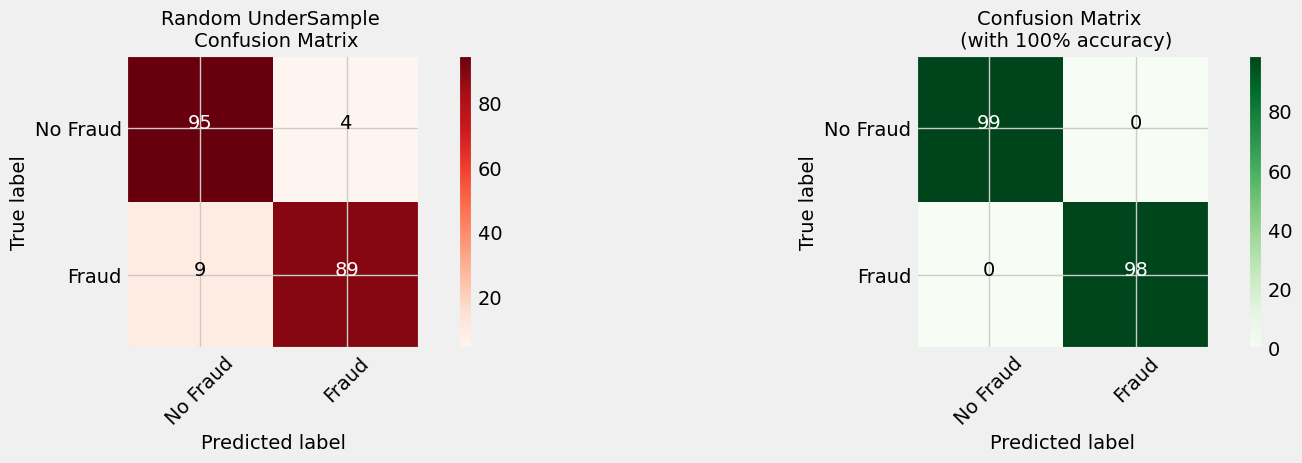

In [111]:
from sklearn.metrics import confusion_matrix
undersample_cm = confusion_matrix(y_test, undersample_fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## <a id='test_over'>Testing on Oversampled data(SMOTe Technique)</a>

In [112]:
n_inputs = original_Xtrain.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [113]:
oversample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 32)                992       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [114]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [115]:
oversample_model.fit(original_Xtrain, original_ytrain, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
608/608 - 3s - loss: 0.0396 - accuracy: 0.9911 - val_loss: 0.0032 - val_accuracy: 0.9995 - 3s/epoch - 6ms/step
Epoch 2/20
608/608 - 3s - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9997 - 3s/epoch - 5ms/step
Epoch 3/20
608/608 - 3s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0020 - val_accuracy: 0.9997 - 3s/epoch - 5ms/step
Epoch 4/20
608/608 - 3s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 0.9998 - 3s/epoch - 5ms/step
Epoch 5/20
608/608 - 5s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9998 - 5s/epoch - 8ms/step
Epoch 6/20
608/608 - 3s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 0.9998 - 3s/epoch - 6ms/step
Epoch 7/20
608/608 - 4s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0017 - val_accuracy: 0.9998 - 4s/epoch - 7ms/step
Epoch 8/20
608/608 - 4s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0017 - val_accuracy: 0.9997 - 4s/epoch - 7ms/step
Epoch 9/20
608/608 - 4s 

In [116]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [117]:
oversample_fraud_predictions = np.argmax(oversample_predictions,axis=1)

Confusion matrix, without normalization
[[56861     2]
 [   32    66]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


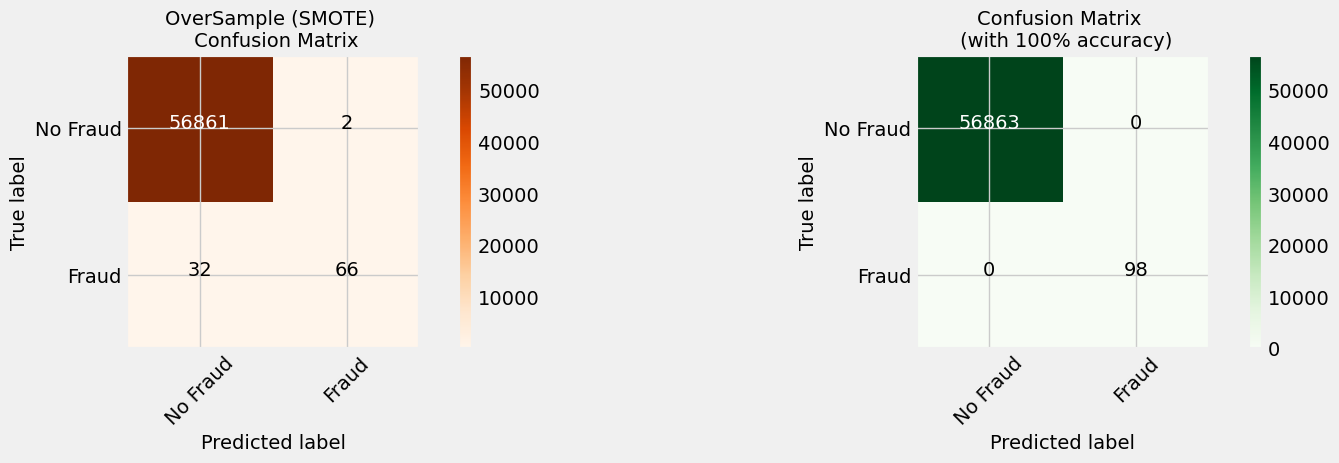

In [118]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# <a id='conc'>Conclusion</a>
In this project, I tried to find a model which would help me predict whether a transaction is fraudulent or non-fraudulent. In order to achieve this, I downloaded a dataset from kaggle whose information is available [here](#dataset). I then performed preprocessing on the dataset and later on did exploratory data analysis on it to study all of its features and to check which all influence a transaction to be fraudulent or non-fraudulent . Initially, I defined a [Naive predictor](#naive) which would act as the benchmark model for all other models that I put to test. After that, I took four different classifiers and tested them on the randomly undersampled dataset and evaluated several metrics on it: accuracy, precision, recall, f1-score. I also plotted learning curves and AUC-ROC curve to get a better understanding of the performance of the 4 classifiers. Oversampling using SMOTe technique was also done on the dataset and then also the metrics were evaluated. Lastly, I used a simple neural network to test the randomly undersampled and oversampled data. In the end, it can be concluded that the neural network performed the best on the oversampled dataset and will be the best model for fraud detection.


# <a id='ref'>References</a>
- https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets